In [117]:
from importlib import reload
import functions
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import pandas as pd
import numpy as np
import math
from sklearn.preprocessing import StandardScaler
reload(functions)

<module 'functions' from 'c:\\Users\\valta\\Documents\\GitHub\\adaml-ml-project\\functions.py'>

In [118]:
data_path = "household_power_consumption.txt"
df = functions.load_data(data_path)
df_hourly = functions.preprocess_data(df, start_date="17/12/2006", end_date="26/11/2010")

In [119]:
last_year = len(df_hourly) - 24*365

# Split data into training/validation and test sets, last year for testing
train_val_data = df_hourly.iloc[:last_year]
test_data = df_hourly.iloc[last_year:]

# Decided to only use the last year as "validation" set in the end, not forecasting currently...
train_data = train_val_data
val_data = test_data



In [120]:
class EnergyData(Dataset):
    def __init__(self, features, targets, window):
        self.features = features
        self.targets = targets
        self.window = window
        
    def __getitem__(self, index):
        x = self.features[index:index+self.window]
        y = self.targets[index+self.window]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)
    
    def __len__(self):
        return len(self.features) - self.window


In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)                      # (max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float32).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model)
        )
        # Even indices: sin, Odd indices: cos
        pe[:, 0::2] = torch.sin(position * div_term)            
        pe[:, 1::2] = torch.cos(position * div_term)            

        pe = pe.unsqueeze(0)                                    # (1, max_len, d_model)
        self.register_buffer("pe", pe)                         

    def forward(self, x):
        # x: (B, S, d_model)
        seq_len = x.size(1)
        x = x + self.pe[:, :seq_len, :]
        return x


In [ ]:
class TransformerModel(nn.Module):
    def __init__(
        self,
        input_size,
        d_model=64,
        nhead=4,
        num_layers=2,
        dim_feedforward=128,
        output_size=1,
        max_len=5000,
    ):
        super().__init__()
        self.input_size = input_size
        self.d_model = d_model

        # projection layer to d_model
        self.input_proj = nn.Linear(input_size, d_model)

        # positional encoding
        self.pos_encoder = PositionalEncoding(d_model, max_len=max_len)
        
        # Transformer Encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            batch_first=True  # (B, S, D)
        )
        self.encoder = nn.TransformerEncoder(
            encoder_layer,
            num_layers=num_layers
        )

        self.fc = nn.Linear(d_model, output_size)

    def forward(self, x):
        # x: (B, S, F)
        h = self.input_proj(x)      # (B, S, d_model)
        h = self.pos_encoder(h)     # add position encoding
        h_enc = self.encoder(h)     # (B, S, d_model)

        last_hidden = h_enc[:, -1, :]   # (B, d_model)

        out = self.fc(last_hidden)      # (B, output_size)
        return out

In [ ]:
input_size = 6   # number of features 
hidden_size = 32 
output_size = 1  # one value to predict
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

loss_fn = nn.MSELoss()
n_epochs = 20
learning_rate = 0.001
window = 24

Y_train = train_data["Global_active_power"].values
X_train = train_data.iloc[:, 1:len(train_data.columns)].values  # oletus: 0. sarake on aika tms.

X_val = val_data.iloc[:, 1:len(val_data.columns)].values
Y_val = val_data["Global_active_power"].values

In [124]:
scalerX = StandardScaler()
scalerY = StandardScaler()

train_X = scalerX.fit_transform(X_train)
val_X   = scalerX.transform(X_val)

train_Y = scalerY.fit_transform(Y_train.reshape(-1, 1))
val_Y   = scalerY.transform(Y_val.reshape(-1, 1))

trainData = EnergyData(train_X, train_Y, window)
valData   = EnergyData(val_X,   val_Y,   window)

trainLoader = DataLoader(trainData, batch_size=32, shuffle=False)
valLoader   = DataLoader(valData,   batch_size=32, shuffle=False)


In [125]:
model = TransformerModel(
    input_size=input_size,
    d_model=64,
    nhead=4,
    num_layers=2,
    dim_feedforward=128,
    output_size=output_size,
    max_len=5000
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

trainLosses = []
valLosses   = []

In [ ]:
for epoch in range(n_epochs):
    model.train()
    epoch_loss = 0.0

    for X_batch, y_batch in trainLoader:
        X_batch = X_batch.to(device)               # (B, window, F)
        y_batch = y_batch.to(device)               # (B, 1)

        optimizer.zero_grad()
        preds = model(X_batch)                     # (B, 1)

        loss = loss_fn(preds, y_batch)

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    # Validaatio
    model.eval()
    preds = []
    truevalids = []
    val_loss = 0.0

    with torch.inference_mode():
        for X_batch, y_batch in valLoader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            pred = model(X_batch)
            loss = loss_fn(pred, y_batch)
            val_loss += loss.item()

            preds.append(pred.detach().cpu().numpy())
            truevalids.append(y_batch.detach().cpu().numpy())

    train_loss_avg = epoch_loss / len(trainLoader)
    val_loss_avg   = val_loss   / len(valLoader)

    print(f"Epoch {epoch+1} / {n_epochs}, Training Loss: {train_loss_avg:.4f}, Validation Loss: {val_loss_avg:.4f}")

    trainLosses.append(train_loss_avg)
    valLosses.append(val_loss_avg)

Epoch 1 / 20, Training Loss: 0.4425, Validation Loss: 0.3860
Epoch 2 / 20, Training Loss: 0.3895, Validation Loss: 0.3956
Epoch 3 / 20, Training Loss: 0.3743, Validation Loss: 0.3561
Epoch 4 / 20, Training Loss: 0.3666, Validation Loss: 0.3611
Epoch 5 / 20, Training Loss: 0.3575, Validation Loss: 0.3638
Epoch 6 / 20, Training Loss: 0.3545, Validation Loss: 0.3742
Epoch 7 / 20, Training Loss: 0.3503, Validation Loss: 0.3393
Epoch 8 / 20, Training Loss: 0.3491, Validation Loss: 0.3369
Epoch 9 / 20, Training Loss: 0.3450, Validation Loss: 0.3209
Epoch 10 / 20, Training Loss: 0.3424, Validation Loss: 0.3409
Epoch 11 / 20, Training Loss: 0.3406, Validation Loss: 0.3189
Epoch 12 / 20, Training Loss: 0.3373, Validation Loss: 0.3319
Epoch 13 / 20, Training Loss: 0.3350, Validation Loss: 0.3359
Epoch 14 / 20, Training Loss: 0.3324, Validation Loss: 0.3258
Epoch 15 / 20, Training Loss: 0.3319, Validation Loss: 0.3229
Epoch 16 / 20, Training Loss: 0.3269, Validation Loss: 0.3378
Epoch 17 / 20, Tr

In [127]:
preds_array      = np.concatenate(preds, axis=0).flatten()
truevalids_array = np.concatenate(truevalids, axis=0).flatten()

preds_real      = scalerY.inverse_transform(preds_array.reshape(-1, 1))
truevalids_real = scalerY.inverse_transform(truevalids_array.reshape(-1, 1))

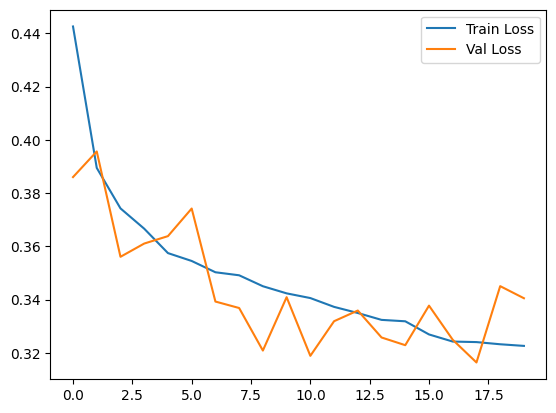

In [ ]:
plt.figure()
plt.plot(trainLosses, label="Train Loss")
plt.plot(valLosses, label="Val Loss")
plt.legend()
plt.show() 

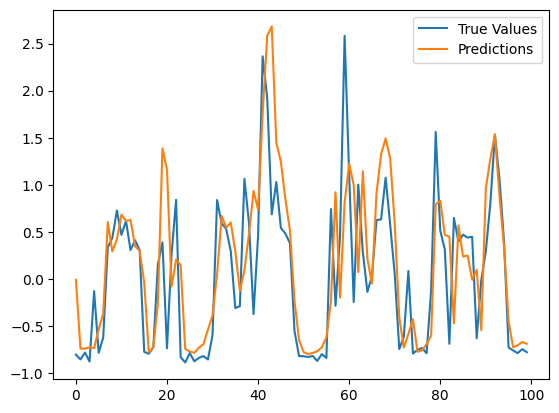

In [129]:
plt.figure()
plt.plot(truevalids_array[:100])
plt.plot(preds_array[:100])
plt.legend(["True Values", "Predictions"])
plt.show()